In [1]:
# Install once if needed:
# !pip install numpy pandas scikit-learn matplotlib seaborn xgboost

import warnings, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve,
    brier_score_loss, classification_report, average_precision_score
)
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.decomposition import PCA

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
print("✅ Imports loaded")


✅ Imports loaded


In [3]:
df = pd.read_csv("cancer.csv")
print("Shape:", df.shape)
df.head()


Shape: (699, 11)


,id,clump_thickness,unif_cell_size,unif_cell_shape,marg_adhesion,single_epith_cell_size,bare_nuclei,bland_chrom,norm_nucleoli,mitoses,classes
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


In [4]:
df_clean = df.copy()

# Drop ID
if 'id' in df_clean.columns:
    df_clean = df_clean.drop(columns=['id'])

# Convert to numeric
for col in df_clean.columns:
    if col != 'classes':
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Missing values
print(df_clean.isna().sum())

# Split X/Y
y = df_clean["classes"].astype(int)
X = df_clean.drop(columns=["classes"])
num_cols = X.columns.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


clump_thickness            0
unif_cell_size             0
unif_cell_shape            0
marg_adhesion              0
single_epith_cell_size     0
bare_nuclei               16
bland_chrom                0
norm_nucleoli              0
mitoses                    0
classes                    0
dtype: int64
Train: (559, 9) Test: (140, 9)


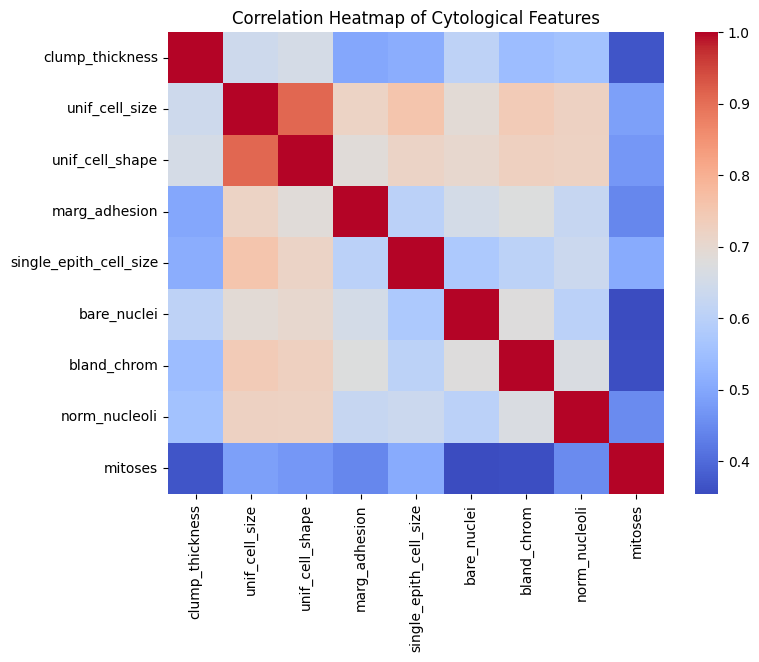

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(X_train.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Cytological Features")
plt.show()


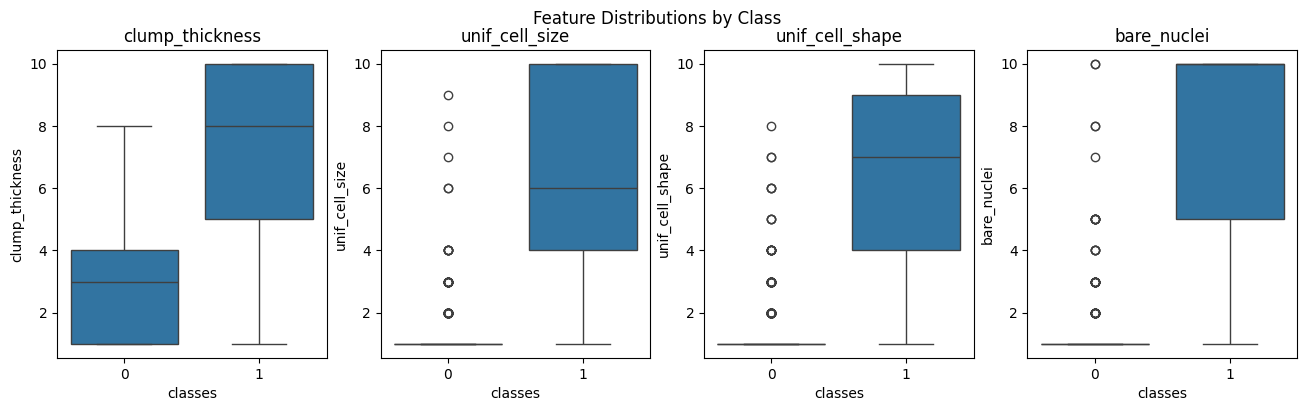

In [6]:
features = ['clump_thickness','unif_cell_size','unif_cell_shape','bare_nuclei']

fig, axes = plt.subplots(1, len(features), figsize=(16,4))
for ax, col in zip(axes, features):
    sns.boxplot(x=y_train, y=X_train[col], ax=ax)
    ax.set_title(col)
plt.suptitle("Feature Distributions by Class")
plt.show()


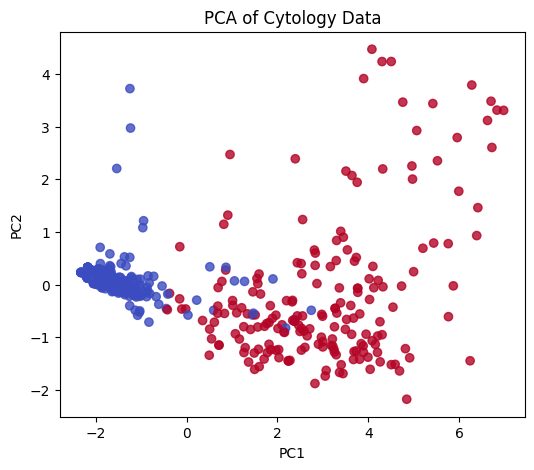

Explained variance: [0.65820661 0.08426502]


In [7]:
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X_train)
sc = StandardScaler()
X_scaled = sc.fit_transform(X_imp)

pca = PCA(n_components=2, random_state=42)
PC = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(PC[:,0], PC[:,1], c=y_train, cmap="coolwarm", alpha=0.8)
plt.title("PCA of Cytology Data")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

print("Explained variance:", pca.explained_variance_ratio_)


In [8]:
prep_scaled = ColumnTransformer([
    ('num', Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('sc', StandardScaler())
    ]), num_cols)
])

prep_tree = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols)
])


In [9]:
pipelines = {
    "logreg": Pipeline([("prep", prep_scaled),
                        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))]),

    "rf": Pipeline([("prep", prep_tree),
                    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))]),

    "svm": Pipeline([("prep", prep_scaled),
                     ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced"))]),

    "xgb": Pipeline([("prep", prep_tree),
                     ("clf", XGBClassifier(
                         n_estimators=300, max_depth=4, learning_rate=0.05,
                         subsample=0.9, colsample_bytree=0.8, eval_metric='logloss',
                         random_state=42, n_jobs=-1
                     ))])
}

param_grids = {
    "logreg": {"clf__C": [0.3, 1, 3]},
    "rf": {"clf__n_estimators": [200, 400], "clf__max_depth": [None, 8, 12]},
    "svm": {"clf__C": [0.5, 1, 2], "clf__gamma": ["scale", 0.05]},
    "xgb": {"clf__max_depth": [3,4], "clf__learning_rate": [0.05, 0.1]}
}

print("Models ready")


Models ready


In [10]:
results = {}
fitted = {}

for name, model in pipelines.items():
    print(f"\n=== Training {name.upper()} ===\n")
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    fitted[name] = grid.best_estimator_
    proba = grid.predict_proba(X_test)[:,1]
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred, average='binary')
    auc = roc_auc_score(y_test, proba)

    results[name] = [acc, prec, rec, f1, auc]
    print(f"Best Params: {grid.best_params_}")
    print(f"AUC: {auc:.3f}")



=== Training LOGREG ===

Best Params: {'clf__C': 0.3}
AUC: 0.995

=== Training RF ===

Best Params: {'clf__max_depth': 8, 'clf__n_estimators': 200}
AUC: 0.991

=== Training SVM ===

Best Params: {'clf__C': 0.5, 'clf__gamma': 0.05}
AUC: 0.992

=== Training XGB ===

Best Params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3}
AUC: 0.991
